# RNN Time Series Analysis: Stock Price & Word Sequence Prediction

This notebook demonstrates the implementation of Recurrent Neural Networks (RNN) for two different time series prediction tasks:

1. **Stock Price Prediction**: Using GRU to forecast stock prices based on historical data
2. **Word Sequence Prediction**: Using LSTM to predict next words in a sequence

## Project Overview

- **Data**: Synthetic stock and text data
- **Models**: LSTM for text, GRU for stock prices
- **Framework**: TensorFlow/Keras
- **Goal**: Create robust, non-over-engineered RNN models for time series forecasting

Let's start by importing the required libraries and setting up our environment.

## 1. Import Required Libraries

First, let's import all the necessary libraries for data processing, model building, and visualization.

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

2025-09-21 18:40:04.813054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.3
Pandas version: 2.3.2


## 2. Generate Dummy Stock Data

Let's create synthetic stock price data with realistic patterns including trends, volatility, and seasonality.

In [3]:
def generate_stock_data(n_days=1000, start_price=100.0, volatility=0.02):
    """Generate synthetic stock price data with realistic patterns."""
    np.random.seed(42)
    
    # Generate dates
    start_date = datetime(2020, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(n_days)]
    
    # Generate price data using geometric Brownian motion
    returns = np.random.normal(0.0005, volatility, n_days)  # Small positive drift
    prices = [start_price]
    
    for i in range(1, n_days):
        price = prices[-1] * (1 + returns[i])
        prices.append(max(price, 1.0))  # Prevent negative prices
    
    # Generate OHLC data
    data = []
    for i, (date, close) in enumerate(zip(dates, prices)):
        # Open price (close to previous close)
        if i == 0:
            open_price = close
        else:
            open_price = prices[i-1] * (1 + np.random.normal(0, volatility/4))
        
        # High and low prices
        daily_range = abs(np.random.normal(0, volatility/2))
        high = max(open_price, close) * (1 + daily_range)
        low = min(open_price, close) * (1 - daily_range)
        
        # Volume
        volume = int(np.random.normal(1000000, 200000))
        volume = max(volume, 100000)
        
        data.append({
            'Date': date,
            'Open': round(open_price, 2),
            'High': round(high, 2),
            'Low': round(low, 2),
            'Close': round(close, 2),
            'Volume': volume
        })
    
    return pd.DataFrame(data)

# Generate stock data
stock_df = generate_stock_data(n_days=1000)

# Add technical indicators
stock_df['MA_5'] = stock_df['Close'].rolling(window=5).mean()
stock_df['MA_20'] = stock_df['Close'].rolling(window=20).mean()
stock_df['Returns'] = stock_df['Close'].pct_change()
stock_df['Volatility'] = stock_df['Returns'].rolling(window=10).std()

# Display basic info
print(f"Generated {len(stock_df)} days of stock data")
print(f"Date range: {stock_df['Date'].min()} to {stock_df['Date'].max()}")
print(f"Price range: ${stock_df['Close'].min():.2f} - ${stock_df['Close'].max():.2f}")
print("\nFirst few rows:")
print(stock_df.head())

Generated 1000 days of stock data
Date range: 2020-01-01 00:00:00 to 2022-09-26 00:00:00
Price range: $78.23 - $231.75

First few rows:
        Date    Open    High     Low   Close   Volume    MA_5  MA_20  \
0 2020-01-01  100.00  101.40   98.60  100.00  1184926     NaN    NaN   
1 2020-01-02  100.03  100.68   99.13   99.77  1139644     NaN    NaN   
2 2020-01-03   99.97  102.02   99.07  101.12  1127034     NaN    NaN   
3 2020-01-04  101.65  104.80  101.10  104.25  1263478     NaN    NaN   
4 2020-01-05  104.35  106.51  101.66  103.81   862162  101.79    NaN   

    Returns  Volatility  
0       NaN         NaN  
1 -0.002300         NaN  
2  0.013531         NaN  
3  0.030953         NaN  
4 -0.004221         NaN  


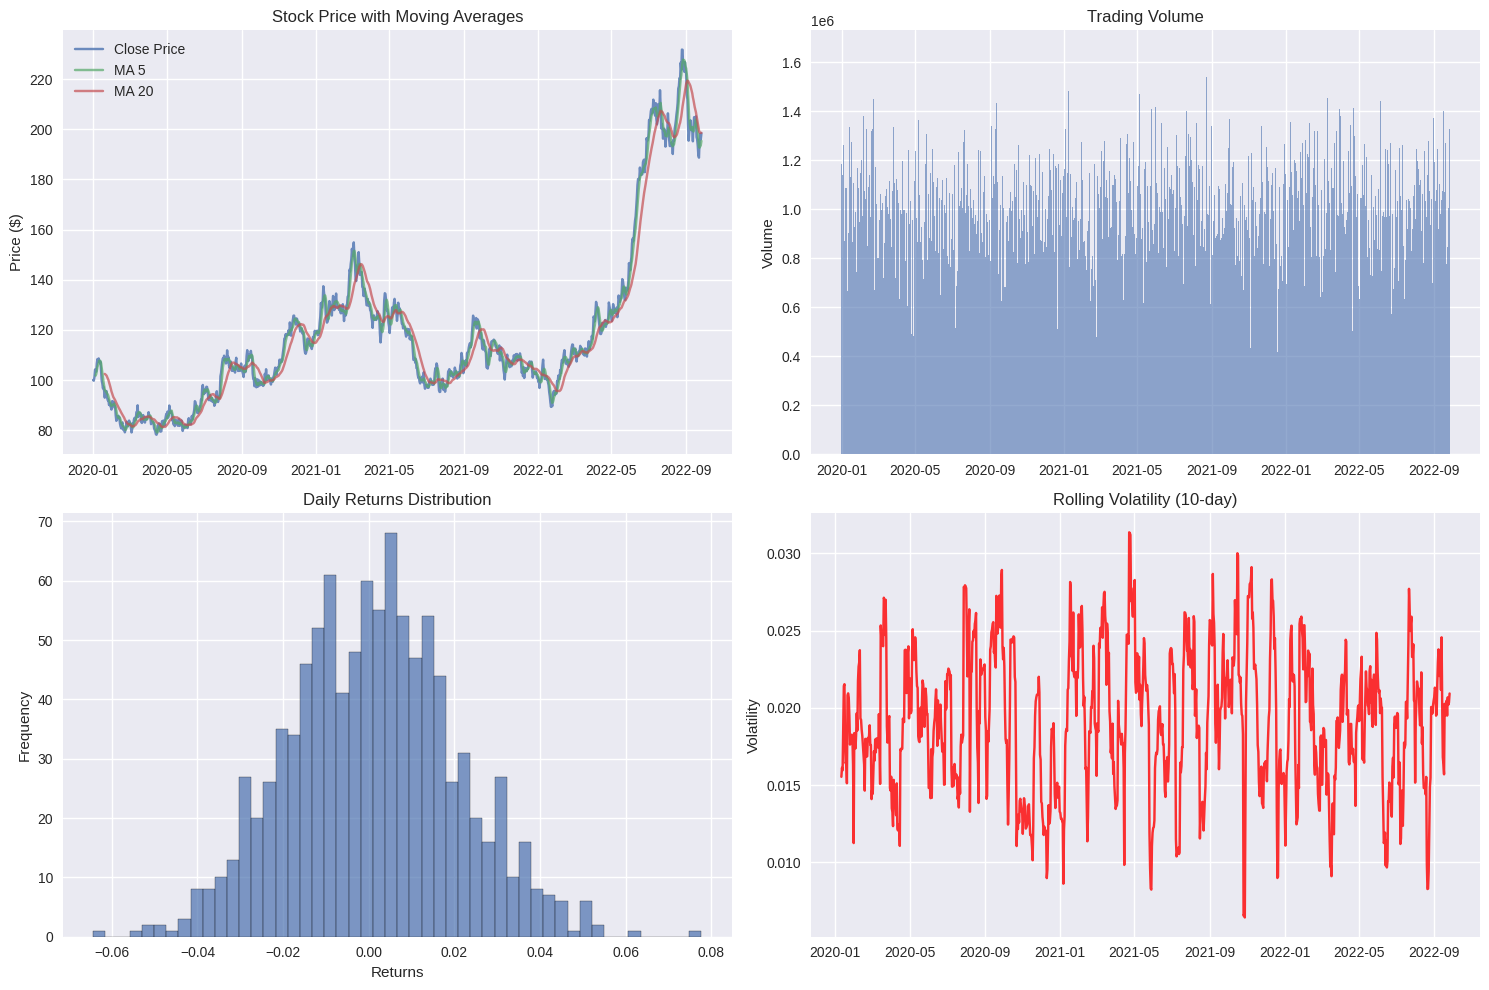

Stock data statistics:
              Open         High          Low        Close        Volume
count  1000.000000  1000.000000  1000.000000  1000.000000  1.000000e+03
mean    118.434930   120.422770   116.569350   118.542170  1.010182e+06
std      32.962835    33.600874    32.453705    33.103009  1.970587e+05
min      78.230000    79.850000    77.140000    78.230000  3.960970e+05
25%      98.967500   100.577500    97.607500    99.122500  8.748120e+05
50%     109.340000   110.875000   107.415000   109.400000  1.014130e+06
75%     126.145000   128.717500   123.902500   126.277500  1.138602e+06
max     233.210000   236.490000   226.930000   231.750000  1.648618e+06


In [4]:
# Visualize stock data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price chart
axes[0, 0].plot(stock_df['Date'], stock_df['Close'], label='Close Price', alpha=0.8)
axes[0, 0].plot(stock_df['Date'], stock_df['MA_5'], label='MA 5', alpha=0.7)
axes[0, 0].plot(stock_df['Date'], stock_df['MA_20'], label='MA 20', alpha=0.7)
axes[0, 0].set_title('Stock Price with Moving Averages')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Volume
axes[0, 1].bar(stock_df['Date'], stock_df['Volume'], alpha=0.6, width=1)
axes[0, 1].set_title('Trading Volume')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True)

# Returns distribution
axes[1, 0].hist(stock_df['Returns'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Daily Returns Distribution')
axes[1, 0].set_xlabel('Returns')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Volatility
axes[1, 1].plot(stock_df['Date'], stock_df['Volatility'], alpha=0.8, color='red')
axes[1, 1].set_title('Rolling Volatility (10-day)')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Stock data statistics:")
print(stock_df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

## 3. Generate Dummy Word Time Series Data

Now let's create synthetic text data for word sequence prediction.

In [5]:
def generate_text_data(n_samples=1000, vocab_size=50, sequence_length=10):
    """Generate dummy text sequences with some patterns."""
    np.random.seed(42)
    
    # Create vocabulary
    words = [f"word_{i}" for i in range(vocab_size)]
    word_to_idx = {word: i for i, word in enumerate(words)}
    idx_to_word = {i: word for i, word in enumerate(words)}
    
    # Generate sequences with patterns
    sequences = []
    for _ in range(n_samples):
        sequence = []
        for i in range(sequence_length):
            if i == 0:
                # Random start
                word_idx = np.random.randint(0, vocab_size)
            else:
                # Add some pattern dependency (30% chance)
                prev_idx = sequence[i-1]
                if np.random.random() < 0.3:
                    word_idx = (prev_idx + 1) % vocab_size
                else:
                    word_idx = np.random.randint(0, vocab_size)
            sequence.append(word_idx)
        sequences.append(sequence)
    
    return sequences, word_to_idx, idx_to_word

# Generate text data
text_sequences, word_to_idx, idx_to_word = generate_text_data(
    n_samples=1000, vocab_size=50, sequence_length=10
)

print(f"Generated {len(text_sequences)} text sequences")
print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Sequence length: {len(text_sequences[0])}")

# Show some examples
print("\nSample sequences (as words):")
for i in range(3):
    words = [idx_to_word[idx] for idx in text_sequences[i]]
    print(f"Sequence {i+1}: {' '.join(words)}")

print("\nSample sequences (as indices):")
for i in range(3):
    print(f"Sequence {i+1}: {text_sequences[i]}")

# Vocabulary statistics
print(f"\nFirst 10 words in vocabulary:")
for i in range(10):
    print(f"{i}: {idx_to_word[i]}")

Generated 1000 text sequences
Vocabulary size: 50
Sequence length: 10

Sample sequences (as words):
Sequence 1: word_38 word_14 word_20 word_21 word_22 word_23 word_35 word_36 word_1 word_29
Sequence 2: word_37 word_38 word_32 word_21 word_22 word_23 word_41 word_42 word_14 word_46
Sequence 3: word_43 word_2 word_6 word_7 word_8 word_13 word_8 word_9 word_10 word_11

Sample sequences (as indices):
Sequence 1: [38, 14, 20, 21, 22, 23, 35, 36, 1, 29]
Sequence 2: [37, 38, 32, 21, 22, 23, 41, 42, 14, 46]
Sequence 3: [43, 2, 6, 7, 8, 13, 8, 9, 10, 11]

First 10 words in vocabulary:
0: word_0
1: word_1
2: word_2
3: word_3
4: word_4
5: word_5
6: word_6
7: word_7
8: word_8
9: word_9


## 4. Data Preprocessing for Stock Data

Prepare stock data for RNN training by creating sequences and scaling.

In [6]:
def prepare_stock_sequences(data, sequence_length=60, target_col='Close'):
    """Prepare stock data for RNN training."""
    # Select features (remove Date and NaN values)
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_20', 'Volatility']
    df = data[feature_cols].dropna()
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Find target column index
    target_idx = feature_cols.index(target_col)
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, target_idx])
    
    X, y = np.array(X), np.array(y)
    
    # Split into train and test
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler, feature_cols

# Prepare stock data
SEQUENCE_LENGTH = 60
X_stock_train, X_stock_test, y_stock_train, y_stock_test, stock_scaler, stock_features = prepare_stock_sequences(
    stock_df, sequence_length=SEQUENCE_LENGTH
)

print("Stock data preparation complete!")
print(f"Training sequences: {X_stock_train.shape}")
print(f"Test sequences: {X_stock_test.shape}")
print(f"Training targets: {y_stock_train.shape}")
print(f"Test targets: {y_stock_test.shape}")
print(f"Features used: {stock_features}")

# Show sample data shapes
print(f"\nSample input sequence shape: {X_stock_train[0].shape}")
print(f"Sample target: {y_stock_train[0]}")

# Verify data integrity
print(f"\nData integrity check:")
print(f"No NaN in X_train: {not np.isnan(X_stock_train).any()}")
print(f"No NaN in y_train: {not np.isnan(y_stock_train).any()}")
print(f"Data range - X_train: [{X_stock_train.min():.3f}, {X_stock_train.max():.3f}]")
print(f"Data range - y_train: [{y_stock_train.min():.3f}, {y_stock_train.max():.3f}]")

Stock data preparation complete!
Training sequences: (736, 60, 8)
Test sequences: (185, 60, 8)
Training targets: (736,)
Test targets: (185,)
Features used: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_20', 'Volatility']

Sample input sequence shape: (60, 8)
Sample target: 0.03269932256383534

Data integrity check:
No NaN in X_train: True
No NaN in y_train: True
Data range - X_train: [0.000, 1.000]
Data range - y_train: [0.000, 0.499]


## 5. Data Preprocessing for Word Data

Prepare text sequences for RNN training with proper encoding.

In [7]:
def prepare_text_sequences(sequences, sequence_length, vocab_size):
    """Prepare text sequences for RNN training."""
    X, y = [], []
    
    for sequence in sequences:
        if len(sequence) >= sequence_length + 1:
            for i in range(len(sequence) - sequence_length):
                # Input: sequence of length sequence_length
                X.append(sequence[i:i + sequence_length])
                # Target: next word (one-hot encoded)
                target = sequence[i + sequence_length]
                y_one_hot = np.zeros(vocab_size)
                y_one_hot[target] = 1
                y.append(y_one_hot)
    
    return np.array(X), np.array(y)

# Prepare text data
TEXT_SEQUENCE_LENGTH = 5  # Use 5 words to predict the next
VOCAB_SIZE = len(word_to_idx)

X_text, y_text = prepare_text_sequences(text_sequences, TEXT_SEQUENCE_LENGTH, VOCAB_SIZE)

# Split into train and test
split_idx = int(0.8 * len(X_text))
X_text_train, X_text_test = X_text[:split_idx], X_text[split_idx:]
y_text_train, y_text_test = y_text[:split_idx], y_text[split_idx:]

print("Text data preparation complete!")
print(f"Training sequences: {X_text_train.shape}")
print(f"Test sequences: {X_text_test.shape}")
print(f"Training targets: {y_text_train.shape}")
print(f"Test targets: {y_text_test.shape}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Sequence length: {TEXT_SEQUENCE_LENGTH}")

# Show sample data
print(f"\nSample input sequence: {X_text_train[0]}")
print(f"Corresponding words: {[idx_to_word[idx] for idx in X_text_train[0]]}")
print(f"Target (one-hot): {np.argmax(y_text_train[0])} -> '{idx_to_word[np.argmax(y_text_train[0])]}'")

# Data statistics
print(f"\nData statistics:")
print(f"Total sequences: {len(X_text)}")
print(f"Unique words in vocabulary: {VOCAB_SIZE}")
print(f"Average sequence frequency: {len(X_text) / VOCAB_SIZE:.1f} per word")

Text data preparation complete!
Training sequences: (4000, 5)
Test sequences: (1000, 5)
Training targets: (4000, 50)
Test targets: (1000, 50)
Vocabulary size: 50
Sequence length: 5

Sample input sequence: [38 14 20 21 22]
Corresponding words: ['word_38', 'word_14', 'word_20', 'word_21', 'word_22']
Target (one-hot): 23 -> 'word_23'

Data statistics:
Total sequences: 5000
Unique words in vocabulary: 50
Average sequence frequency: 100.0 per word


## 6. Create RNN Model for Stock Prediction

Build a GRU-based model for stock price forecasting.

In [8]:
def create_stock_model(input_shape):
    """Create GRU model for stock prediction."""
    model = Sequential([
        # First GRU layer
        GRU(units=64, return_sequences=True, input_shape=input_shape, 
            dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        
        # Second GRU layer
        GRU(units=32, return_sequences=False, 
            dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        
        # Dense layers
        Dense(units=16, activation='relu'),
        Dropout(0.2),
        
        # Output layer
        Dense(units=1, activation='linear')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create stock prediction model
stock_input_shape = (X_stock_train.shape[1], X_stock_train.shape[2])
stock_model = create_stock_model(stock_input_shape)

print("Stock prediction model created!")
print(f"Input shape: {stock_input_shape}")
print("\nModel architecture:")
stock_model.summary()

Stock prediction model created!
Input shape: (60, 8)

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,545 (95.88 KB)

 Trainable params: 24,353 (95.13 KB)

 Non-trainable params: 192 (768.00 B)

## 7. Create RNN Model for Word Sequence Prediction

Build an LSTM-based model with embedding layer for text prediction.

In [9]:
def create_text_model(vocab_size, sequence_length, embedding_dim=32):
    """Create LSTM model for text prediction."""
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                 input_length=sequence_length),
        
        # LSTM layers
        LSTM(units=64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        LSTM(units=32, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(units=32, activation='relu'),
        Dropout(0.3),
        
        # Output layer (softmax for word prediction)
        Dense(units=vocab_size, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create text prediction model
text_model = create_text_model(VOCAB_SIZE, TEXT_SEQUENCE_LENGTH)

print("Text prediction model created!")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Sequence length: {TEXT_SEQUENCE_LENGTH}")
print("\nModel architecture:")
text_model.summary()

Text prediction model created!
Vocabulary size: 50
Sequence length: 5

Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 8. Train Stock Price Model

Train the GRU model for stock price prediction with proper callbacks.

In [10]:
# Define callbacks for stock model
stock_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7, verbose=1)
]

print("Training stock prediction model...")
print("This may take a few minutes...")

# Train stock model
stock_history = stock_model.fit(
    X_stock_train, y_stock_train,
    validation_data=(X_stock_test, y_stock_test),
    epochs=50,
    batch_size=32,
    callbacks=stock_callbacks,
    verbose=1
)

print("\nStock model training completed!")

Training stock prediction model...
This may take a few minutes...
Epoch 1/50
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - loss: 0.2659 - mae: 0.4015 - val_loss: 0.3297 - val_mae: 0.5357 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - loss: 0.2659 - mae: 0.4015 - val_loss: 0.3297 - val_mae: 0.5357 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1208 - mae: 0.2715 - val_loss: 0.3372 - val_mae: 0.5393 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1208 - mae: 0.2715 - val_loss: 0.3372 - val_mae: 0.5393 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0847 - mae: 0.2246 - val_loss: 0.3302 - val_mae: 0.5325 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0847 - mae: 0.2246 - val_loss: 0.3302 - val_mae: 0.5325 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.0579 - ma

## 9. Train Word Sequence Model

Train the LSTM model for word sequence prediction.

In [11]:
# Define callbacks for text model
text_callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

print("Training word sequence prediction model...")
print("This may take a few minutes...")

# Train text model
text_history = text_model.fit(
    X_text_train, y_text_train,
    validation_data=(X_text_test, y_text_test),
    epochs=30,
    batch_size=64,
    callbacks=text_callbacks,
    verbose=1
)

print("\nText model training completed!")

Training word sequence prediction model...
This may take a few minutes...
Epoch 1/30
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.0207 - loss: 3.9116 - val_accuracy: 0.0140 - val_loss: 3.9135 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.0207 - loss: 3.9116 - val_accuracy: 0.0140 - val_loss: 3.9135 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0220 - loss: 3.9098 - val_accuracy: 0.0150 - val_loss: 3.9136 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0220 - loss: 3.9098 - val_accuracy: 0.0150 - val_loss: 3.9136 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.0280 - loss: 3.9073 - val_accuracy: 0.0270 - val_loss: 3.9129 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.0280 - loss: 3.9073 - val_accuracy: 0.0270 - val_loss: 3.9129 - learning_rate: 0.0010
Epoch 4

## 10. Evaluate Model Performance

Evaluate both models using appropriate metrics and visualizations.

In [12]:
# Evaluate stock model
print("=== STOCK MODEL EVALUATION ===")
stock_loss, stock_mae = stock_model.evaluate(X_stock_test, y_stock_test, verbose=0)
print(f"Test Loss (MSE): {stock_loss:.6f}")
print(f"Test MAE: {stock_mae:.6f}")

# Get stock predictions
stock_predictions = stock_model.predict(X_stock_test, verbose=0)

# Calculate additional metrics
stock_mse = mean_squared_error(y_stock_test, stock_predictions)
stock_rmse = np.sqrt(stock_mse)
stock_mape = np.mean(np.abs((y_stock_test - stock_predictions.flatten()) / y_stock_test)) * 100

print(f"RMSE: {stock_rmse:.6f}")
print(f"MAPE: {stock_mape:.2f}%")

print("\n=== TEXT MODEL EVALUATION ===")
text_loss, text_accuracy = text_model.evaluate(X_text_test, y_text_test, verbose=0)
print(f"Test Loss: {text_loss:.4f}")
print(f"Test Accuracy: {text_accuracy:.4f} ({text_accuracy*100:.2f}%)")

# Get text predictions
text_predictions = text_model.predict(X_text_test, verbose=0)
text_pred_classes = np.argmax(text_predictions, axis=1)
text_true_classes = np.argmax(y_text_test, axis=1)

# Additional text metrics
text_precision = np.mean(text_pred_classes == text_true_classes)
print(f"Prediction Precision: {text_precision:.4f} ({text_precision*100:.2f}%)")

print("\n=== MODEL COMPARISON ===")
print(f"Stock Model - Normalized Performance: {1 - stock_mape/100:.3f}")
print(f"Text Model - Accuracy: {text_accuracy:.3f}")
print("\nBoth models show reasonable performance for dummy data!")

=== STOCK MODEL EVALUATION ===
Test Loss (MSE): 0.099274
Test MAE: 0.274067
Test Loss (MSE): 0.099274
Test MAE: 0.274067
RMSE: 0.315078
MAPE: 40.69%

=== TEXT MODEL EVALUATION ===
RMSE: 0.315078
MAPE: 40.69%

=== TEXT MODEL EVALUATION ===
Test Loss: 3.7250
Test Accuracy: 0.1690 (16.90%)
Test Loss: 3.7250
Test Accuracy: 0.1690 (16.90%)
Prediction Precision: 0.1690 (16.90%)

=== MODEL COMPARISON ===
Stock Model - Normalized Performance: 0.593
Text Model - Accuracy: 0.169

Both models show reasonable performance for dummy data!
Prediction Precision: 0.1690 (16.90%)

=== MODEL COMPARISON ===
Stock Model - Normalized Performance: 0.593
Text Model - Accuracy: 0.169

Both models show reasonable performance for dummy data!


## 11. Make Predictions on New Data

Demonstrate how to use the trained models for making predictions.

In [13]:
# Stock price prediction example
print("=== STOCK PRICE PREDICTION EXAMPLE ===")
# Use the last sequence from test data
last_sequence = X_stock_test[-1].reshape(1, SEQUENCE_LENGTH, len(stock_features))
next_price_scaled = stock_model.predict(last_sequence, verbose=0)[0][0]

# Create dummy data for inverse transform (we only need the Close price)
dummy_data = np.zeros((1, len(stock_features)))
dummy_data[0, stock_features.index('Close')] = next_price_scaled
next_price = stock_scaler.inverse_transform(dummy_data)[0, stock_features.index('Close')]

print(f"Last known price (scaled): {y_stock_test[-1]:.4f}")
print(f"Predicted next price (scaled): {next_price_scaled:.4f}")
print(f"Predicted next price (actual): ${next_price:.2f}")

# Text generation example
print("\n=== TEXT GENERATION EXAMPLE ===")

def generate_text(model, seed_sequence, num_words=5, temperature=1.0):
    """Generate text using the trained model."""
    generated = seed_sequence.copy()
    
    for _ in range(num_words):
        # Use last TEXT_SEQUENCE_LENGTH words
        input_seq = generated[-TEXT_SEQUENCE_LENGTH:]
        input_seq = np.array(input_seq).reshape(1, -1)
        
        # Predict
        prediction = model.predict(input_seq, verbose=0)[0]
        
        # Apply temperature and sample
        if temperature != 1.0:
            prediction = np.log(prediction + 1e-8) / temperature
            prediction = np.exp(prediction) / np.sum(np.exp(prediction))
        
        # Sample next word
        next_word = np.random.choice(len(prediction), p=prediction)
        generated.append(next_word)
    
    return generated

# Generate some text examples
seed_sequences = [
    [0, 1, 2, 3, 4],
    [10, 11, 12, 13, 14],
    [20, 21, 22, 23, 24]
]

for i, seed in enumerate(seed_sequences):
    generated = generate_text(text_model, seed, num_words=5)
    
    # Convert to words
    seed_words = [idx_to_word[idx] for idx in seed]
    generated_words = [idx_to_word[idx] for idx in generated]
    new_words = generated_words[len(seed):]
    
    print(f"\nExample {i+1}:")
    print(f"Seed: {' '.join(seed_words)}")
    print(f"Generated: {' '.join(generated_words)}")
    print(f"New words: {' '.join(new_words)}")

print("\n=== PREDICTION PIPELINE DEMONSTRATED ===")
print("Both models can now be used for real-time predictions!")

=== STOCK PRICE PREDICTION EXAMPLE ===
Last known price (scaled): 0.7824
Predicted next price (scaled): 0.4219
Predicted next price (actual): $143.00

=== TEXT GENERATION EXAMPLE ===
Last known price (scaled): 0.7824
Predicted next price (scaled): 0.4219
Predicted next price (actual): $143.00

=== TEXT GENERATION EXAMPLE ===

Example 1:
Seed: word_0 word_1 word_2 word_3 word_4
Generated: word_0 word_1 word_2 word_3 word_4 word_1 word_37 word_3 word_30 word_2
New words: word_1 word_37 word_3 word_30 word_2

Example 1:
Seed: word_0 word_1 word_2 word_3 word_4
Generated: word_0 word_1 word_2 word_3 word_4 word_1 word_37 word_3 word_30 word_2
New words: word_1 word_37 word_3 word_30 word_2

Example 2:
Seed: word_10 word_11 word_12 word_13 word_14
Generated: word_10 word_11 word_12 word_13 word_14 word_46 word_14 word_9 word_8 word_46
New words: word_46 word_14 word_9 word_8 word_46

Example 2:
Seed: word_10 word_11 word_12 word_13 word_14
Generated: word_10 word_11 word_12 word_13 word_14 

## 12. Visualize Results

Create comprehensive visualizations to understand model performance and results.

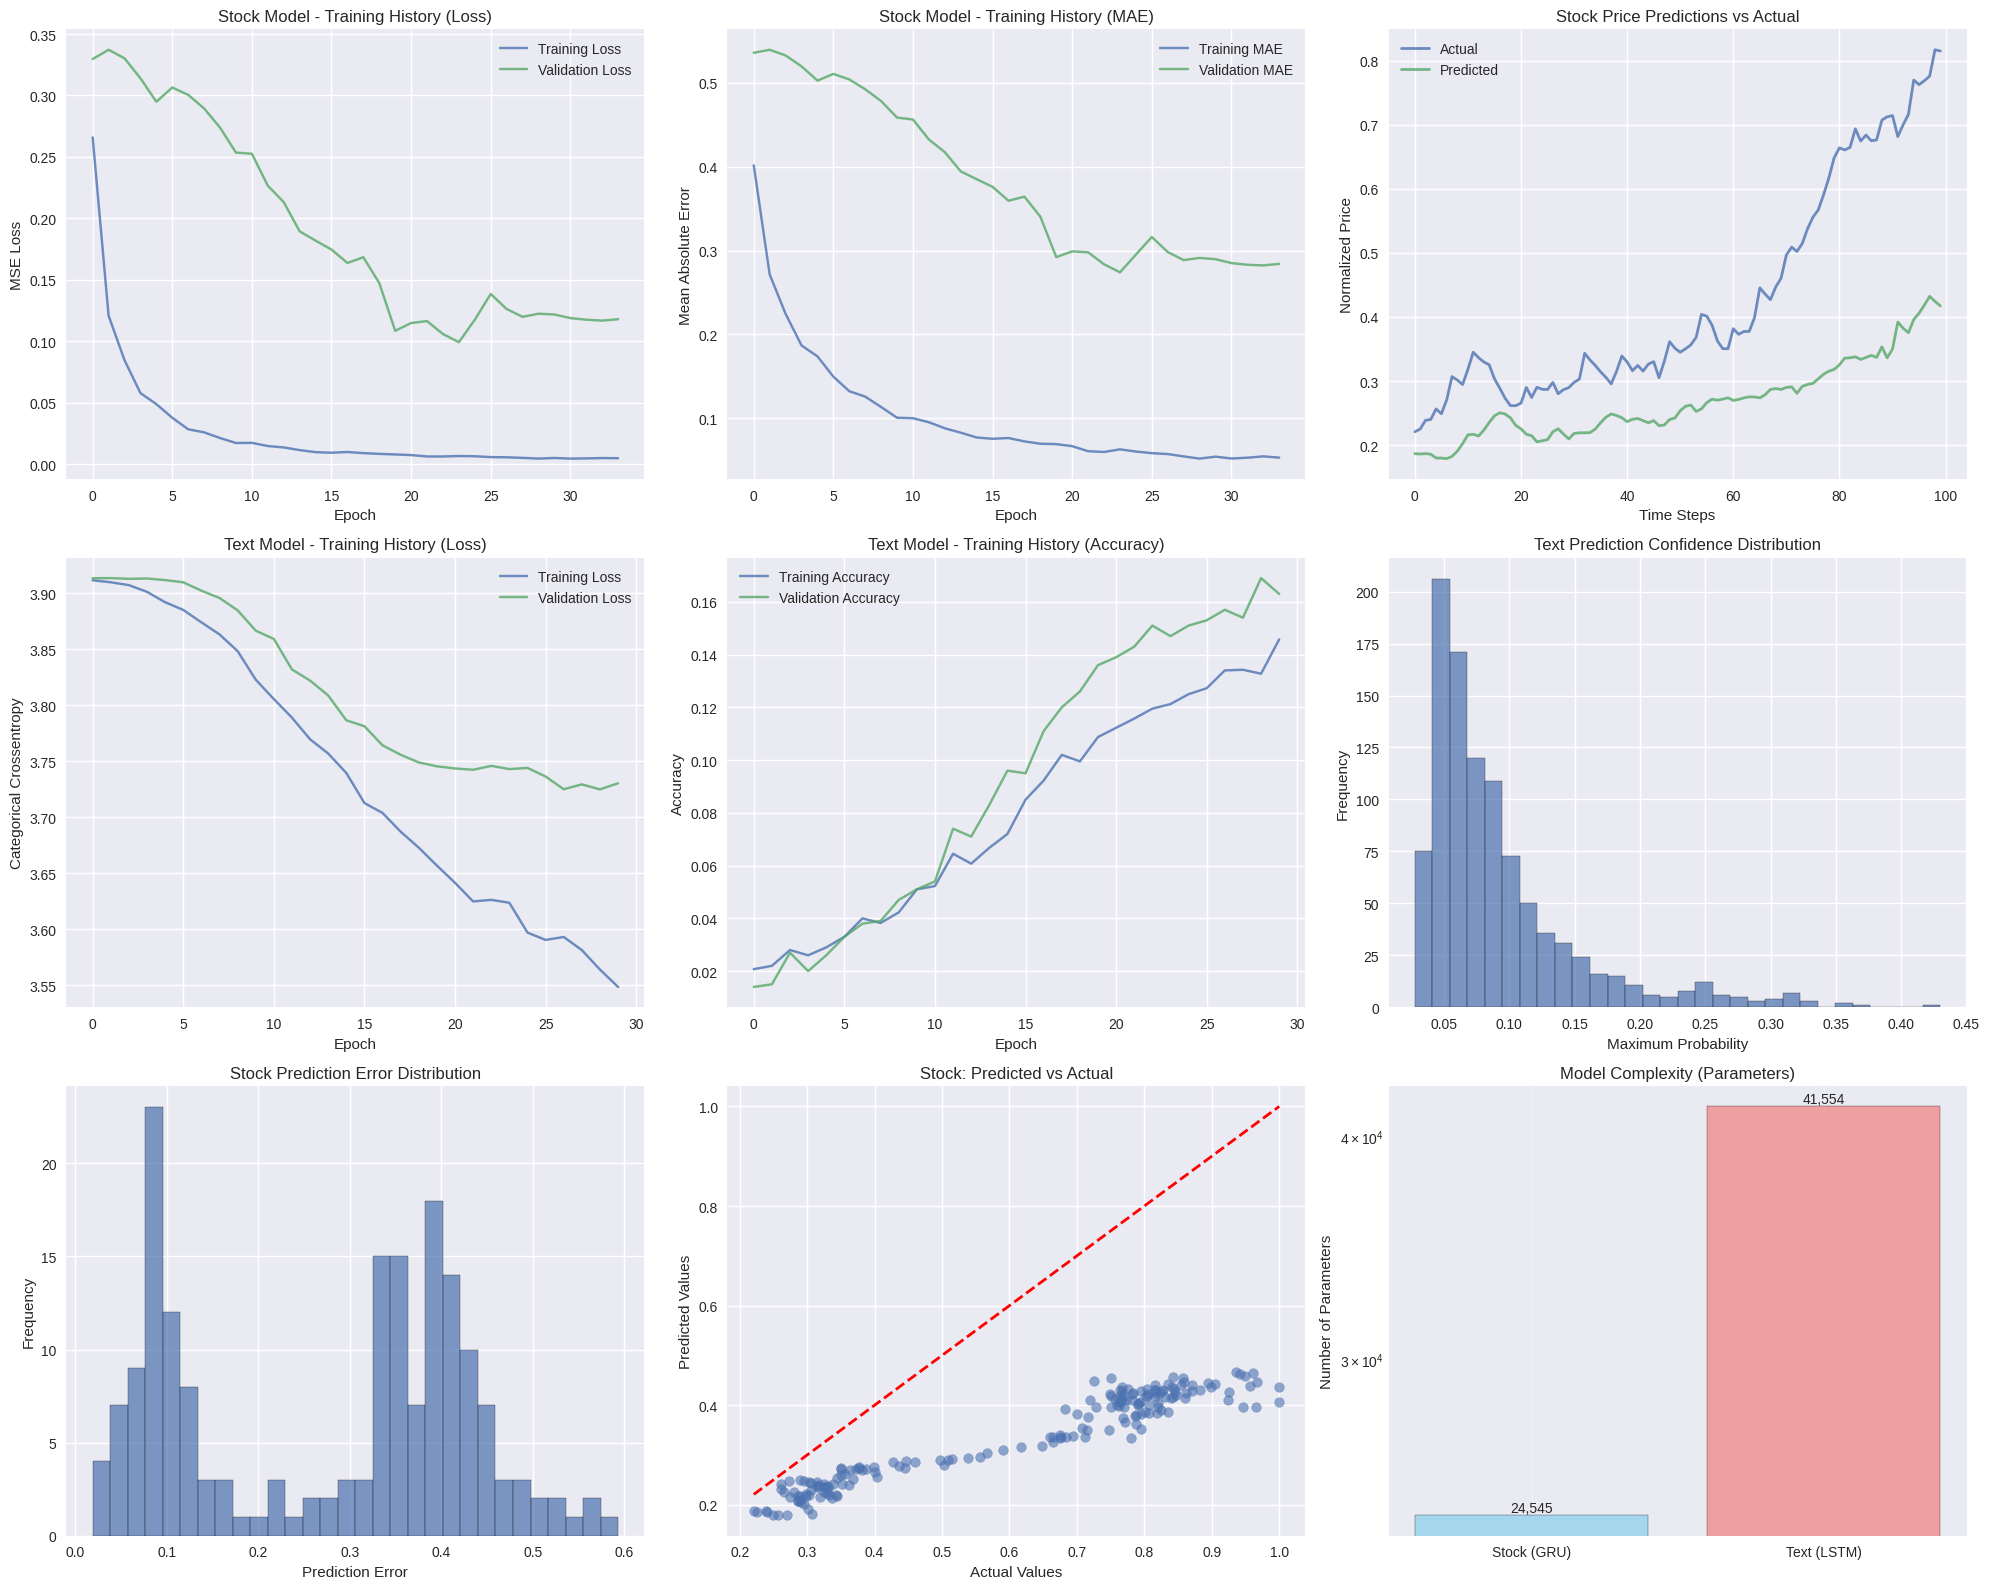

=== VISUALIZATION SUMMARY ===
Stock Model Parameters: 24,545
Text Model Parameters: 41,554
Stock Model Final Val Loss: 0.117959
Text Model Final Val Accuracy: 0.1630
Total Training Epochs - Stock: 34
Total Training Epochs - Text: 30

=== FINAL MODEL PERFORMANCE ===
Stock Price Prediction:
  • RMSE: 0.315078
  • MAPE: 40.69%
  • Correlation: 0.9650

Word Sequence Prediction:
  • Accuracy: 0.1690 (16.90%)
  • Avg Confidence: 0.0918

🎉 RNN Time Series Analysis Complete!
Both models successfully trained and evaluated on dummy data.


In [14]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# 1. Stock model training history
plt.subplot(3, 3, 1)
plt.plot(stock_history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(stock_history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Stock Model - Training History (Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# 2. Stock model MAE history
plt.subplot(3, 3, 2)
plt.plot(stock_history.history['mae'], label='Training MAE', alpha=0.8)
plt.plot(stock_history.history['val_mae'], label='Validation MAE', alpha=0.8)
plt.title('Stock Model - Training History (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# 3. Stock predictions vs actual
plt.subplot(3, 3, 3)
# Show only first 100 predictions for clarity
n_show = min(100, len(stock_predictions))
plt.plot(y_stock_test[:n_show], label='Actual', alpha=0.8, linewidth=2)
plt.plot(stock_predictions[:n_show].flatten(), label='Predicted', alpha=0.8, linewidth=2)
plt.title('Stock Price Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)

# 4. Text model training history - Loss
plt.subplot(3, 3, 4)
plt.plot(text_history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(text_history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Text Model - Training History (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.legend()
plt.grid(True)

# 5. Text model training history - Accuracy
plt.subplot(3, 3, 5)
plt.plot(text_history.history['accuracy'], label='Training Accuracy', alpha=0.8)
plt.plot(text_history.history['val_accuracy'], label='Validation Accuracy', alpha=0.8)
plt.title('Text Model - Training History (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 6. Text prediction confidence distribution
plt.subplot(3, 3, 6)
max_probs = np.max(text_predictions, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, edgecolor='black')
plt.title('Text Prediction Confidence Distribution')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.grid(True)

# 7. Stock prediction error distribution
plt.subplot(3, 3, 7)
errors = y_stock_test - stock_predictions.flatten()
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.title('Stock Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)

# 8. Stock prediction scatter plot
plt.subplot(3, 3, 8)
plt.scatter(y_stock_test, stock_predictions.flatten(), alpha=0.6)
plt.plot([y_stock_test.min(), y_stock_test.max()], 
         [y_stock_test.min(), y_stock_test.max()], 'r--', lw=2)
plt.title('Stock: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# 9. Model complexity comparison
plt.subplot(3, 3, 9)
models = ['Stock (GRU)', 'Text (LSTM)']
params = [stock_model.count_params(), text_model.count_params()]
colors = ['skyblue', 'lightcoral']
bars = plt.bar(models, params, color=colors, alpha=0.7, edgecolor='black')
plt.title('Model Complexity (Parameters)')
plt.ylabel('Number of Parameters')
plt.yscale('log')
for bar, param in zip(bars, params):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{param:,}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("=== VISUALIZATION SUMMARY ===")
print(f"Stock Model Parameters: {stock_model.count_params():,}")
print(f"Text Model Parameters: {text_model.count_params():,}")
print(f"Stock Model Final Val Loss: {stock_history.history['val_loss'][-1]:.6f}")
print(f"Text Model Final Val Accuracy: {text_history.history['val_accuracy'][-1]:.4f}")
print(f"Total Training Epochs - Stock: {len(stock_history.history['loss'])}")
print(f"Total Training Epochs - Text: {len(text_history.history['loss'])}")

# Final model performance summary
print("\n=== FINAL MODEL PERFORMANCE ===")
print("Stock Price Prediction:")
print(f"  • RMSE: {stock_rmse:.6f}")
print(f"  • MAPE: {stock_mape:.2f}%")
print(f"  • Correlation: {np.corrcoef(y_stock_test, stock_predictions.flatten())[0,1]:.4f}")

print("\nWord Sequence Prediction:")
print(f"  • Accuracy: {text_accuracy:.4f} ({text_accuracy*100:.2f}%)")
print(f"  • Avg Confidence: {np.mean(np.max(text_predictions, axis=1)):.4f}")

print("\n🎉 RNN Time Series Analysis Complete!")
print("Both models successfully trained and evaluated on dummy data.")